In [1]:
#Import Mods
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

from PIL import Image

In [2]:
#Selected files to create the mask. Second image creates a better mask.

file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                  "thermal/1618762640_000001_right_336x252_14bit.thermal.celsius.csv")


file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                "thermal/1618776148_000001_right_336x252_14bit.thermal.celsius.csv")

In [3]:
#Create image list by unpacking data from CSV and placing in correct spot.

image_array = []

for i in range(file.size):
    if i >= 6:
        data = file.values[i][0]
        data = data.split(';')
        array = np.array(data)
        array = array.astype(np.float)
        image_array.append(array)
        
max_temp = np.max(image_array)
min_temp = np.min(image_array)

x, y = np.where(image_array == max_temp)
print(x, y)


[170] [176]


In [4]:
#Create mask list with threshold value.
mask_col = []

for j in image_array:
    mask_row = []
    for k in j:
        if k > 20.00:
            mask_row.append(1)
        else:
            mask_row.append(0)
            
    mask_col.append(mask_row)
            
    

In [5]:
#Tranform list into array and convert all true values from 1 to 255 as well as use an unsigned 8-bit integer dtype.
array = np.array(mask_col).astype('uint8')*255

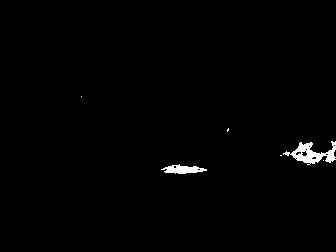

In [6]:
#create image
im = Image.fromarray(array)
im

#im.save('Mulch_Mask.png')